# STL-10 Dataset

In [3]:
# -*- coding: utf-8 -*-
"""
Spyder Editor

This is a temporary script file.
"""

import os
import urllib.request as urllib
import tarfile
import sys

import keras
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K, regularizers
from keras.callbacks import LearningRateScheduler
from keras.engine.training import Model
from keras.layers import Add, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation, Input
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from vis.visualization import visualize_cam
import matplotlib.cm as cm
# the dimensions of each image in the STL-10 dataset (96x96x3).
HEIGHT, WIDTH, DEPTH = 96, 96, 3

# number of classes in the STL-10 dataset.
N_CLASSES = 10

# size of a single image in bytes
SIZE = HEIGHT * WIDTH * DEPTH

# path to the directory with the data
DATA_DIR = './stl10_data'

# url of the binary data
DATA_URL = 'http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz'

# path to the binary train file with image data
TRAIN_DATA_PATH = DATA_DIR + '/stl10_binary/train_X.bin'

# path to the binary test file with image data
TEST_DATA_PATH = DATA_DIR + '/stl10_binary/test_X.bin'

# path to the binary train file with labels
TRAIN_LABELS_PATH = DATA_DIR + '/stl10_binary/train_y.bin'

# path to the binary test file with labels
TEST_LABELS_PATH = DATA_DIR + '/stl10_binary/test_y.bin'

# path to class names file
CLASS_NAMES_PATH = DATA_DIR + '/stl10_binary/class_names.txt'

def read_labels(path_to_labels):
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels


def read_all_images(path_to_data):
    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, DEPTH, WIDTH, HEIGHT))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images


def download_and_extract():
    # if the dataset already exists locally, no need to download it again.
    if all((
        os.path.exists(TRAIN_DATA_PATH),
        os.path.exists(TRAIN_LABELS_PATH),
        os.path.exists(TEST_DATA_PATH),
        os.path.exists(TEST_LABELS_PATH),
    )):
        return

    dest_directory = DATA_DIR
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
        
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\rDownloading %s %.2f%%' % (filename,
                                                          float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()

        filepath, _ = urllib.urlretrieve(DATA_URL, filepath, reporthook=_progress)
        print('Downloaded', filename)
        tarfile.open(filepath, 'r:gz').extractall(dest_directory)


def load_dataset():
    # download the extract the dataset.
    download_and_extract()

    # load the train and test data and labels.
    x_train = read_all_images(TRAIN_DATA_PATH)
    y_train = read_labels(TRAIN_LABELS_PATH)
    x_test = read_all_images(TEST_DATA_PATH)
    y_test = read_labels(TEST_LABELS_PATH)

    # convert all images to floats in the range [0, 1]
    x_train = x_train.astype('float32')
    x_train = (x_train - 127.5) / 127.5
    x_test = x_test.astype('float32')
    x_test = (x_test - 127.5) / 127.5
    
    # convert the labels to be zero based.
    y_train -= 1
    y_test -= 1

    # convert labels to hot-one vectors.
    y_train = keras.utils.to_categorical(y_train, N_CLASSES)
    y_test = keras.utils.to_categorical(y_test, N_CLASSES)
    x_train -= np.mean(x_train, axis = 0)
    x_test -= np.mean(x_test, axis = 0)
    
    
    return (x_train, y_train), (x_test, y_test)

(x_test, y_test) , (x_train, y_train)= load_dataset()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.2, random_state=5)




Using TensorFlow backend.


(8000, 96, 96, 3) (8000, 10) (5000, 96, 96, 3) (5000, 10)


# Data augmentation
Data augmentation using MixupGenerator and ImageDataGenerator

In [4]:
class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y    
    
datagen = ImageDataGenerator(
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
   
   )
training_generator = MixupGenerator(x_train, y_train, batch_size=128, alpha=0.5, datagen=datagen)()



# CNN Model

In [5]:

def build_classifier_model():
    n_conv_blocks = 4  # number of convolution blocks to have in our model.
    n_filters = 16 # number of filters to use in the first convolution block.
    l2_reg = regularizers.l2(2e-4)  # weight to use for L2 weight decay. 
    activation = 'elu'  # the activation function to use after each linear operation.

    if K.image_data_format() == 'channels_first':
        input_shape = (3, HEIGHT, WIDTH)
    else:
        input_shape = (HEIGHT, WIDTH, 3)

    x = input_1 = Input(shape=input_shape)
    
    # each convolution block consists of two sub-blocks of Conv->Batch-Normalization- bn>Activation,
    # followed by a Max-Pooling and a Dropout layer.
    for i in range(n_conv_blocks):
        shortcut = Conv2D(filters=n_filters, kernel_size=(1, 1), padding='same', kernel_regularizer=l2_reg)(x)
        x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', kernel_regularizer=l2_reg)(x)
        x = BatchNormalization()(x)
        x = Activation(activation=activation)(x)
        
        x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', kernel_regularizer=l2_reg)(x)
        x = Add()([shortcut, x])
        x = BatchNormalization()(x)
        x = Activation(activation=activation)(x)
        
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(rate=0.25)(x)
        
        n_filters *= 2

    # finally, we flatten the output of the last convolution block, and add two Fully-Connected layers.
    x = Flatten()(x)
    x = Dense(units=512, kernel_regularizer=l2_reg)(x)
    x = BatchNormalization()(x)
    x = Activation(activation=activation)(x)

    x = Dropout(rate=0.5)(x)
    x = Dense(units=N_CLASSES, kernel_regularizer=l2_reg)(x)
    output = Activation(activation='softmax')(x)

    return Model(inputs=[input_1], outputs=[output])


model = build_classifier_model()
model.summary()  


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 96, 96, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 96, 96, 16)   64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 96, 96, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_1 (

# Learning rate scheduling & Model fit

In [6]:
def train_classifier(model_output_path=None, batch_size=128, epochs = 200, initial_lr=1e-3):    
    def lr_scheduler(epoch):
        if epoch < 40:
            return initial_lr
        elif epoch < 80:
            return initial_lr / 2
        elif epoch < 120:
            return initial_lr / 4
        elif epoch < 160:
            return initial_lr / 8
        elif epoch < 180:
            return initial_lr / 16     
        else:
            return initial_lr / 32

    model.compile( 
        loss='categorical_crossentropy',
        optimizer=keras.optimizers.Adam(initial_lr),
        metrics=['accuracy']
    )

    history = model.fit_generator(
    generator=training_generator,
    steps_per_epoch = int(np.ceil(x_train.shape[0] / float(batch_size))),
    epochs = epochs,
    validation_data=(x_val, y_val),
    callbacks=[LearningRateScheduler(lr_scheduler)]
)
  

    if model_output_path is not None:
        print('saving trained model to:', model_output_path)
        model.save(model_output_path)
        
    return history


history = train_classifier()


Epoch 1/200
63/63 [==============================] - 22s 355ms/step - loss: 2.6935 - acc: 0.2932 - val_loss: 1.8777 - val_acc: 0.4670
Epoch 2/200
63/63 [==============================] - 20s 310ms/step - loss: 2.3126 - acc: 0.3580 - val_loss: 1.8238 - val_acc: 0.4800
Epoch 3/200
63/63 [==============================] - 19s 307ms/step - loss: 2.1974 - acc: 0.3941 - val_loss: 1.7208 - val_acc: 0.4800
Epoch 4/200
63/63 [==============================] - 20s 311ms/step - loss: 2.1008 - acc: 0.4281 - val_loss: 1.7391 - val_acc: 0.4570
Epoch 5/200
63/63 [==============================] - 19s 297ms/step - loss: 2.0243 - acc: 0.4583 - val_loss: 1.7076 - val_acc: 0.4930
Epoch 6/200
63/63 [==============================] - 19s 298ms/step - loss: 1.9652 - acc: 0.4828 - val_loss: 1.5351 - val_acc: 0.5530
Epoch 7/200
63/63 [==============================] - 18s 292ms/step - loss: 1.8985 - acc: 0.5051 - val_loss: 1.5593 - val_acc: 0.5290
Epoch 8/200
63/63 [==============================] - 18s 292ms

Epoch 62/200
63/63 [==============================] - 19s 295ms/step - loss: 1.2700 - acc: 0.7361 - val_loss: 0.8156 - val_acc: 0.7870
Epoch 63/200
63/63 [==============================] - 19s 295ms/step - loss: 1.2814 - acc: 0.7364 - val_loss: 0.8309 - val_acc: 0.7880
Epoch 64/200
63/63 [==============================] - 19s 298ms/step - loss: 1.2685 - acc: 0.7367 - val_loss: 0.8346 - val_acc: 0.7790
Epoch 65/200
63/63 [==============================] - 19s 298ms/step - loss: 1.2734 - acc: 0.7378 - val_loss: 0.8389 - val_acc: 0.7620
Epoch 66/200
63/63 [==============================] - 18s 293ms/step - loss: 1.2658 - acc: 0.7406 - val_loss: 0.8674 - val_acc: 0.7560
Epoch 67/200
63/63 [==============================] - 19s 296ms/step - loss: 1.2701 - acc: 0.7401 - val_loss: 0.8731 - val_acc: 0.7640
Epoch 68/200
63/63 [==============================] - 19s 295ms/step - loss: 1.2642 - acc: 0.7385 - val_loss: 0.8225 - val_acc: 0.7840
Epoch 69/200
63/63 [==============================] - 1

63/63 [==============================] - 18s 286ms/step - loss: 1.0841 - acc: 0.8180 - val_loss: 0.6612 - val_acc: 0.8230
Epoch 123/200
63/63 [==============================] - 18s 283ms/step - loss: 1.0800 - acc: 0.8090 - val_loss: 0.6635 - val_acc: 0.8210
Epoch 124/200
63/63 [==============================] - 19s 298ms/step - loss: 1.0803 - acc: 0.8151 - val_loss: 0.6394 - val_acc: 0.8300
Epoch 125/200
63/63 [==============================] - 19s 308ms/step - loss: 1.0855 - acc: 0.8069 - val_loss: 0.6466 - val_acc: 0.8330
Epoch 126/200
63/63 [==============================] - 19s 301ms/step - loss: 1.0677 - acc: 0.8194 - val_loss: 0.6587 - val_acc: 0.8310
Epoch 127/200
63/63 [==============================] - 19s 305ms/step - loss: 1.0655 - acc: 0.8192 - val_loss: 0.6373 - val_acc: 0.8300
Epoch 128/200
63/63 [==============================] - 19s 298ms/step - loss: 1.0633 - acc: 0.8120 - val_loss: 0.6663 - val_acc: 0.8290
Epoch 129/200
63/63 [==============================] - 19s 301

63/63 [==============================] - 19s 308ms/step - loss: 0.9971 - acc: 0.8470 - val_loss: 0.5988 - val_acc: 0.8350
Epoch 183/200
63/63 [==============================] - 19s 300ms/step - loss: 1.0051 - acc: 0.8424 - val_loss: 0.5912 - val_acc: 0.8440
Epoch 184/200
63/63 [==============================] - 19s 304ms/step - loss: 0.9914 - acc: 0.8434 - val_loss: 0.5904 - val_acc: 0.8410
Epoch 185/200
63/63 [==============================] - 19s 296ms/step - loss: 0.9890 - acc: 0.8486 - val_loss: 0.5911 - val_acc: 0.8370
Epoch 186/200
63/63 [==============================] - 19s 300ms/step - loss: 0.9810 - acc: 0.8502 - val_loss: 0.5931 - val_acc: 0.8400
Epoch 187/200
63/63 [==============================] - 19s 302ms/step - loss: 1.0087 - acc: 0.8390 - val_loss: 0.5925 - val_acc: 0.8400
Epoch 188/200
63/63 [==============================] - 19s 305ms/step - loss: 0.9937 - acc: 0.8462 - val_loss: 0.5886 - val_acc: 0.8460
Epoch 189/200
63/63 [==============================] - 20s 310

# Test Score

In [7]:
score, acc = model.evaluate(x_test, y_test, verbose = 0)
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 0.5462525885105133
Test accuracy: 0.86425


# Plot loss function, train-val accuracy

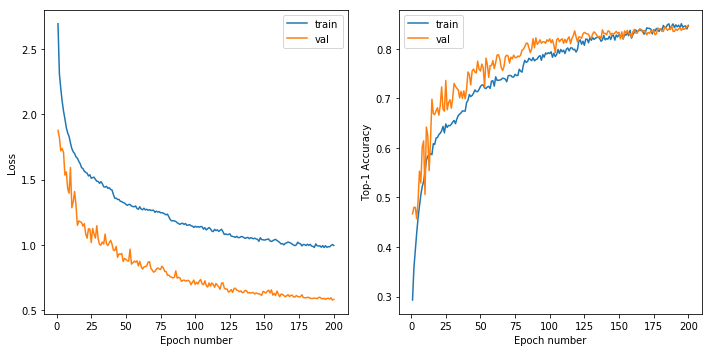

In [22]:
def plot_training_history(history):
    loss, val_loss = history.history['loss'], history.history['val_loss']
    epochs = len(loss)
    
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    axs[0].plot(np.arange(1, epochs + 1), loss, label='train')
    axs[0].plot(np.arange(1, epochs + 1), val_loss, label='val')
    axs[0].set_xlabel('Epoch number')
    axs[0].set_ylabel('Loss')
    axs[0].legend(loc="best")

    acc, val_acc = history.history['acc'], history.history['val_acc']
    axs[1].plot(np.arange(1, epochs + 1), acc, label='train')
    axs[1].plot(np.arange(1, epochs + 1), val_acc, label='val')
    axs[1].set_xlabel('Epoch number')
    axs[1].set_ylabel('Top-1 Accuracy')
    axs[1].legend(loc="best")
    
    plt.tight_layout()
    plt.show()
    
    
plot_training_history(history)


# GradCam

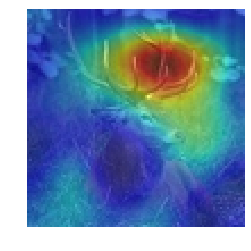

deer: 95.5%, cat: 1.6%, airplane: 0.9%, monkey: 0.8%, bird: 0.5%
predicted class = 4, true class = 4, image index = 121


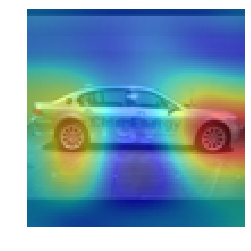

car: 94.4%, airplane: 3.0%, deer: 0.5%, truck: 0.5%, cat: 0.5%
predicted class = 2, true class = 2, image index = 4


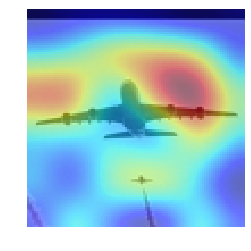

airplane: 96.7%, deer: 1.0%, monkey: 0.9%, bird: 0.7%, dog: 0.4%
predicted class = 0, true class = 0, image index = 19


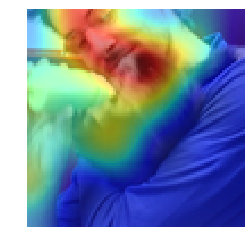

dog: 46.8%, monkey: 38.8%, bird: 7.3%, horse: 3.8%, cat: 1.4%
predicted class = 5, true class = 7, image index = 3338


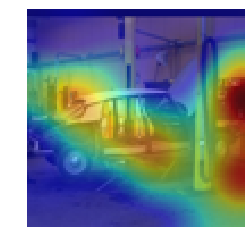

truck: 72.8%, car: 17.0%, cat: 5.0%, horse: 1.3%, ship: 1.2%
predicted class = 9, true class = 2, image index = 1331


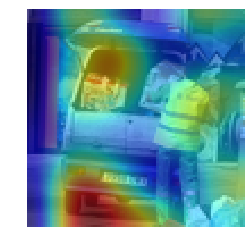

car: 44.8%, truck: 43.6%, horse: 4.6%, dog: 2.9%, cat: 1.3%
predicted class = 2, true class = 9, image index = 138


In [157]:
def load_label_names():
    # load the STL-10 class label names.
    with open(CLASS_NAMES_PATH, 'r') as f:
        return np.array([l.strip() for l in f])


label_names = load_label_names()


def get_prediction(x, top_n=5):
    # get the model's prediction on x.
    predictions = model.predict(x)[0]
    predictions *= 100
    
    # get the predictions sorted indices in reversed order.
    order = np.argsort(predictions)[::-1]
    
    # print the top_n predictions along with their class labels, in revered order.
    sorted_predictions = list(zip(label_names[order], predictions[order]))
    print(', '.join(['{}: {:.1f}%'.format(label, confidence) for label, confidence in sorted_predictions[:top_n]]))


from random import *

def plot_images(n_images, q):
    

    img_idx = q
    images = x_test[img_idx, np.newaxis]
    img = np.expand_dims(x_test[img_idx], axis=0)
    pred_class = np.argmax(model.predict(img))
    actual_class = np.argmax(y_test[img_idx])

       
    layer_name = model.layers[-2].name
    layer_idx = [idx for idx, layer in enumerate(model.layers) if layer.name == layer_name][0]
    
    heatmap = visualize_cam(model, layer_idx, filter_indices = pred_class, 
                              seed_input = x_test[img_idx])
    heatmap = np.uint8(cm.jet(heatmap)[..., :3] * 255)
    
    _, h, w, d = images.shape
    # create an array that will store the images to plot.
    canvas = np.empty((h * n_images, w * n_images, d), dtype='uint8')

    for i in range(n_images):
        img_column = images[i * n_images:(i + 1) * n_images]
        for j in range(n_images):
            if j >= img_column.shape[0]:
                break

            # transform images to the range [0, 255]
            img_2 = img_column[j]
            img_2 = ((img * 127.5) + 127.5).clip(0, 255).astype('uint8')            
            canvas[i * h:(i + 1) * h, j * w:(j + 1) * w] = img_2 
    
    plt.figure(figsize=(2 * n_images, 2 * n_images))
    plt.axis('off')
    cmap = 'gray' if d == 1 else None
    plt.imshow(canvas.squeeze(), origin="upper", cmap=cmap)
    plt.imshow(heatmap, alpha = 0.5)
    plt.show()
    get_prediction(img)
    print("predicted class = {}, true class = {}, image index = {}".format(pred_class, actual_class, img_idx))



plot_images(2, 121)
plot_images(2, 4)
plot_images(2, 19)
plot_images(2, 3338)
plot_images(2, 1331)
plot_images(2, 138)